In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.misc
import os

from ImageUtils import *
from imageio import imread
from scipy.io import loadmat
from scipy.stats import entropy
from scipy.special import kolmogorov
from scipy import ndimage
import seaborn as sns

## Behavioral Data - Pooling Region Size

In [3]:
### Get behavioral data

# Get the gram matrices
gram_mtx = np.load('tmp/gram_mtx.npy').item()
l = loadmat('/Users/akshay/proj/TextureSynthesis/tmp/imslopes.mat', chars_as_strings=True, mat_dtype=True)

# slopes of the Accuracy vs RF Size graphs for each image for each cnn layer.
imslopes = l['imslopes']
lnm = l['layernames']
layernames = [str(lnm[0][0][0]), str(lnm[0][1][0]), str(lnm[0][2][0])]
imnames = np.array([str(l['imnames'][0][i][0]) for i in range(15)], dtype='string_')

In [4]:
# At each layer, compute the correlation between every pair of subset gram matrices 
nSubsets = gram_mtx['pool1'].shape[2]
layers = ['pool1', 'pool2', 'pool4']
ims = imnames
im_corrs = np.zeros((len(ims), len(layers)))
im_vars = np.zeros((len(ims)))

for imi in range(len(ims)):
    im = ims[imi]
    gram_mtx = np.load('tmp/gram_%s.npy' % (im)).item()
    corrs = []
    for li in layers:
        #print li
        gm = gram_mtx[li]
        sub_comb = np.array(np.meshgrid(range(nSubsets), range(nSubsets))).T.reshape(-1,2)
        cs = []
        for si in range(sub_comb.shape[0]):
            s1,s2 = sub_comb[si]
            if s1 != s2:
                sub1 = gm[:,:,s1]
                sub2 = gm[:,:,s2]
                subcorr = np.corrcoef(sub1.flatten(), sub2.flatten())[0,1].astype(float)
                cs.append(subcorr)
        corrs.append(np.mean(cs))
    #print im, np.mean(corrs)
    im_corrs[imi,:] = corrs

print im_corrs

[[ 0.88343304  0.9439072   0.69230832]
 [ 0.88877262  0.7443293   0.52837079]
 [ 0.97221493  0.87780915  0.45770628]
 [ 0.90457533  0.8832499   0.66497926]
 [ 0.94410816  0.93359974  0.63331679]
 [ 0.89987992  0.76218887  0.51936434]
 [ 0.99214854  0.92184001  0.63260811]
 [ 0.77146569  0.68269754  0.55890187]
 [ 0.83590052  0.60726355  0.65648752]
 [ 0.96226423  0.87577256  0.57645861]
 [ 0.97136587  0.92234316  0.61501899]
 [ 0.93049625  0.80561828  0.57429745]
 [ 0.77180438  0.7920338   0.45171558]
 [ 0.90952306  0.8545905   0.47579342]
 [ 0.91175743  0.81822654  0.76316276]]


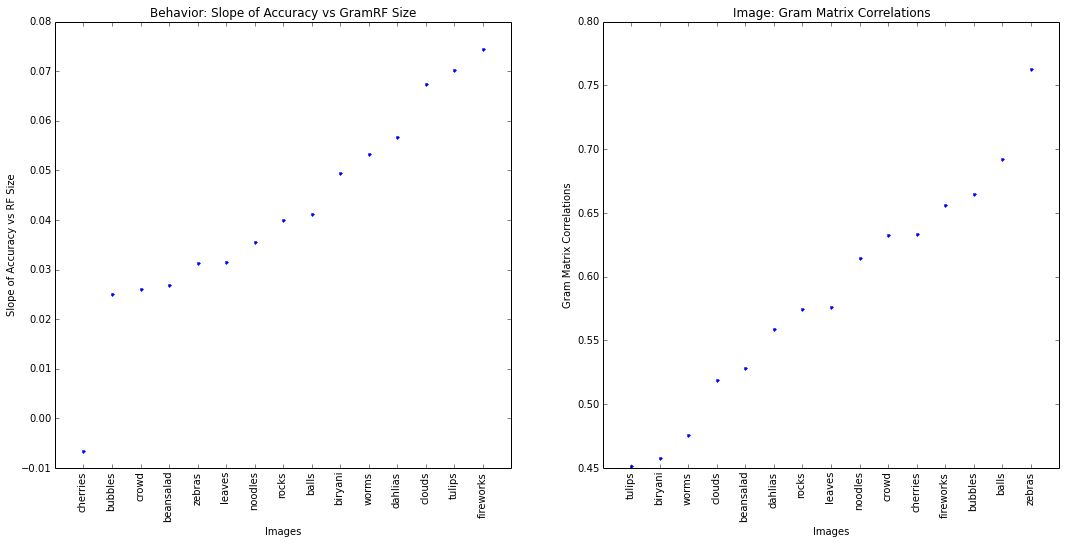

In [5]:
## Plot Behavioral data and Image Statistics for each image
fig = plt.figure(figsize=(18,8))

mim = np.mean(imslopes,axis=1)
sidx = np.argsort(mim)
ax = fig.add_subplot(121)
plt.plot(range(len(imnames)), mim[sidx], '.')
#plt.legend(layernames,loc='upper left')
ax.set_xticks(range(len(imnames)))
ax.set_xticklabels(imnames[sidx], rotation=90)
plt.xlabel('Images')
plt.ylabel('Slope of Accuracy vs RF Size')
plt.title('Behavior: Slope of Accuracy vs GramRF Size')
plt.xlim([-1, 15]);

mim = np.mean(im_corrs,axis=1)
mim = im_corrs[:,2]
sidx = np.argsort(mim)
ax = fig.add_subplot(122)
plt.plot(range(len(imnames)), mim[sidx], '.')
#plt.legend(layernames,loc='upper left')
ax.set_xticks(range(len(imnames)))
ax.set_xticklabels(imnames[sidx], rotation=90)
plt.xlabel('Images')
plt.ylabel('Gram Matrix Correlations')
plt.title('Image: Gram Matrix Correlations')
plt.xlim([-1, 15]);
#plt.savefig('Figures/im_slopes')

### Comparing Gram Matrix Correlation to Behavior (effect of pooling region size)

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


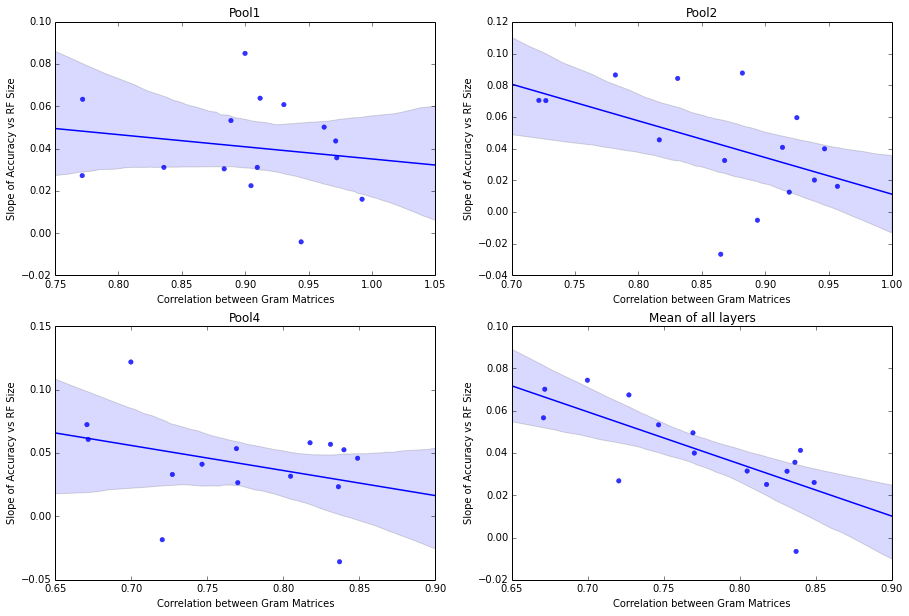

In [6]:
#im_corrs.shape = [15,3]
#imslopes.shape = [15,3]

fig = plt.figure(figsize=(15,10))

ax = fig.add_subplot(221)
sns.regplot(x=im_corrs[:,0], y = imslopes[:,0])
plt.xlabel('Correlation between Gram Matrices')
plt.ylabel('Slope of Accuracy vs RF Size')
plt.title('Pool1')

ax = fig.add_subplot(222)
sns.regplot(x=np.mean(im_corrs[:,0:2], axis=1), y = imslopes[:,1])
plt.xlabel('Correlation between Gram Matrices')
plt.ylabel('Slope of Accuracy vs RF Size')
plt.title('Pool2')

ax = fig.add_subplot(223)
sns.regplot(x=np.mean(im_corrs[:,:], axis=1), y = imslopes[:,2])
plt.xlabel('Correlation between Gram Matrices')
plt.ylabel('Slope of Accuracy vs RF Size')
plt.title('Pool4')

ax = fig.add_subplot(224)
sns.regplot(x=np.mean(im_corrs,axis=1), y=np.mean(imslopes,axis=1))
plt.xlabel('Correlation between Gram Matrices')
plt.ylabel('Slope of Accuracy vs RF Size')
plt.title('Mean of all layers')

#plt.savefig('Figures/Slope_vs_Corr')

X-Axis: Computed the gram matrices split into 4x4 pooling regions. Took the pairwise correlation of each sub-gram matrix with each other sub-gram matrix at each layer. And averaged across layers.

Y-Axis: Behavioral data -- computed the slope of the best fit line in the Accuracy vs RF size graph. 

In [7]:
## Behavioral Data - Feature Complexity
sqz = np.squeeze

# Load behavioral data: trial-by-trial vectors
l = loadmat('/Users/akshay/proj/TextureSynthesis/behavioral_data.mat', chars_as_strings=True)
subj_resp, corr_resp, tr_corr = sqz(l['subj_resp']), sqz(l['corr_resp']), sqz(l['corr_trials'])
tr_img, tr_layer, tr_rfSz = sqz(l['image']), sqz(l['layer']), sqz(l['rf_size'])

# Get image names and layer names
lsp = loadmat('/Users/akshay/proj/TextureSynthesis/tmp/imslopes_layer.mat', chars_as_strings=True)
layernames = np.array([str(lsp['layernames'][0][i][0]) for i in range(3)], dtype='string_')
imnames = np.array([str(lsp['imnames'][0][i][0]) for i in range(15)], dtype='string_')

# Compute mean performance for each image on each layer
accuracy = np.zeros((len(ims), len(layernames)))
for imi in range(len(ims)):
    #im = ims[imi]
    for li in range(len(layernames)):
        idx = np.all(np.stack((tr_img==imi+1, tr_layer==li+1)), axis=0)
        accuracy[imi, li] = np.nanmean(tr_corr[idx])

acc_diff = np.array([accuracy[:,0]-accuracy[:,1], accuracy[:,1]-accuracy[:,2]]).T
#print accuracy.shape, acc_diff.shape

# Compute variance of the gram matrix at each layer
im_vars = np.zeros((len(ims), len(layernames)))
im_means = np.zeros((len(ims), len(layernames)))
nSubsets = 1

for imi in range(len(ims)):
    im = ims[imi]
    gram_mtx = np.load('tmp/gram_1_%s.npy' % (im)).item()
    for li in range(len(layers)):
        gm = gram_mtx[layers[li]]
        nFilt = gm.shape[0]
        im_vars[imi,li] = np.var(gm.flatten())
        im_means[imi,li] = np.mean(gm.flatten())

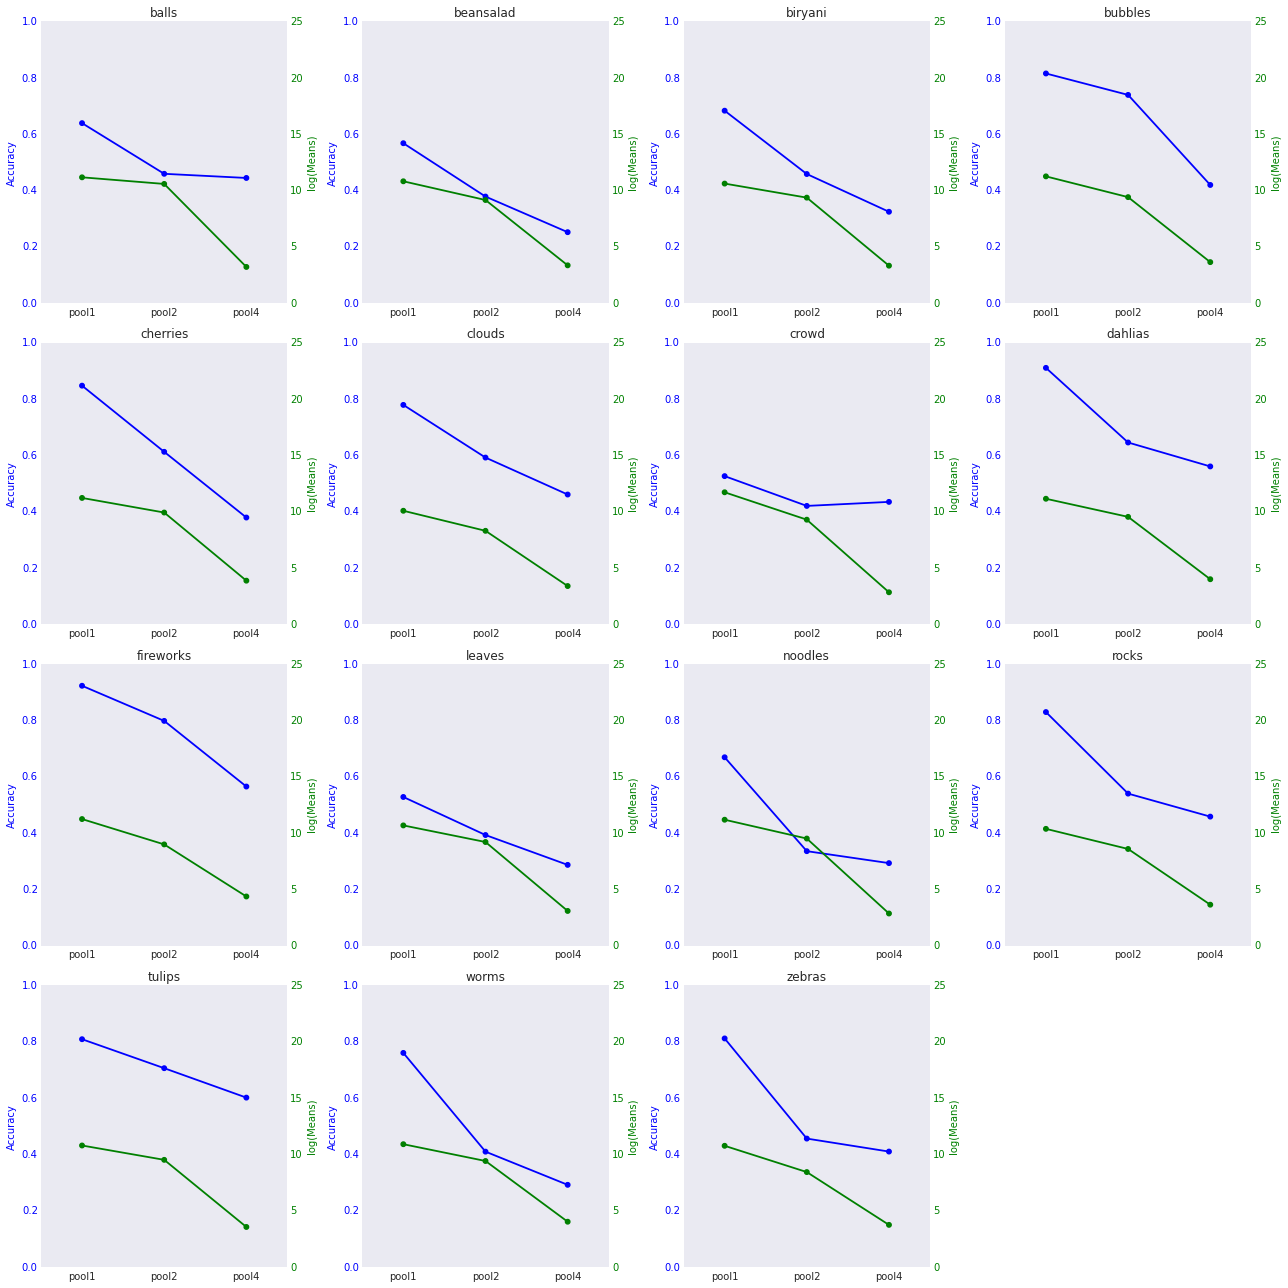

In [8]:
# Plot both the behavior and the variance of each gram matrix on the same graph for each image.
fig = plt.figure(figsize=(18,18))
sns.set_style('dark')

for imi in range(len(ims)):
    ax1 = fig.add_subplot(4,4,imi+1)
    ax1.set_title(ims[imi])
    #ax1.set_xlabel('Layer')
    lx = [1,2,3]
    
    # Plot the behavior
    sns.pointplot(x=lx, y=accuracy[imi], ax=ax1, color='b')
    ax1.set_ylabel('Accuracy', color='b')
    ax1.set_ylim([0, 1])
    ax1.tick_params('y', colors='b')
    
    # On the same x-axis, plot the Gram Matrix statistics
    ax2 = ax1.twinx()
    yval = np.log(im_vars[imi,:])
    sns.pointplot(x=lx, y=np.log(im_means[imi,:]), ax=ax2, color='g')
    ax2.set_ylabel('log(Means)', color='g')
    ax2.tick_params('y', colors='g')
    ax2.set_ylim([0, 25])
    
    ax1.set_xticklabels(layernames)

fig.tight_layout()
#plt.savefig('Figures/Accuracy_Mean_by_img')

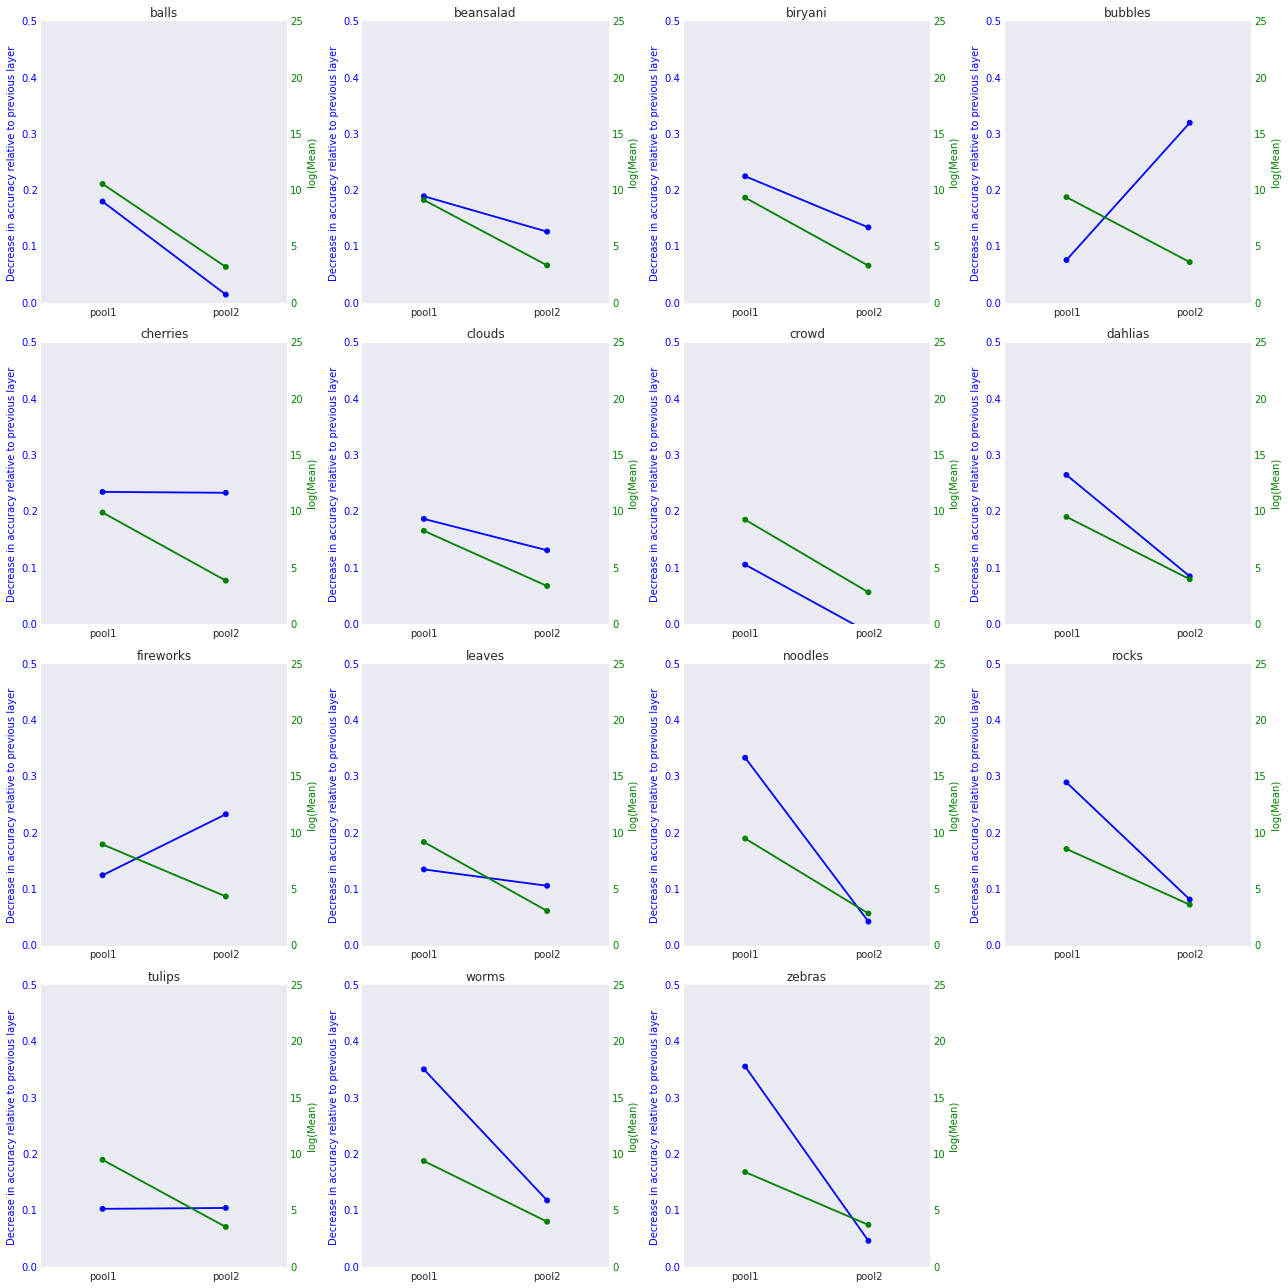

In [9]:
# Plot both the behavior and the variance of each gram matrix on the same graph for each image.
fig = plt.figure(figsize=(18,18))
sns.set_style('dark')

for imi in range(len(ims)):
    ax1 = fig.add_subplot(4,4,imi+1)
    ax1.set_title(ims[imi])
    #ax1.set_xlabel('Layer')
    lx = [1,2]
    
    # Plot the behavior
    sns.pointplot(x=lx, y=acc_diff[imi,:], ax=ax1, color='b')
    ax1.set_ylabel('Decrease in accuracy relative to previous layer', color='b')
    ax1.set_ylim([0, .5])
    ax1.tick_params('y', colors='b')
    
    # On the same x-axis, plot the Gram Matrix statistics
    ax2 = ax1.twinx()
    yval = np.log(im_vars[imi,:])
    sns.pointplot(x=lx, y=np.log(im_means[imi,1:]), ax=ax2, color='g')
    ax2.set_ylabel('log(Mean)', color='g')
    ax2.tick_params('y', colors='g')
    ax2.set_ylim([0, 25])
    
    ax1.set_xticklabels(layernames)

fig.tight_layout()
#plt.savefig('Figures/Accuracy_Mean_by_img')

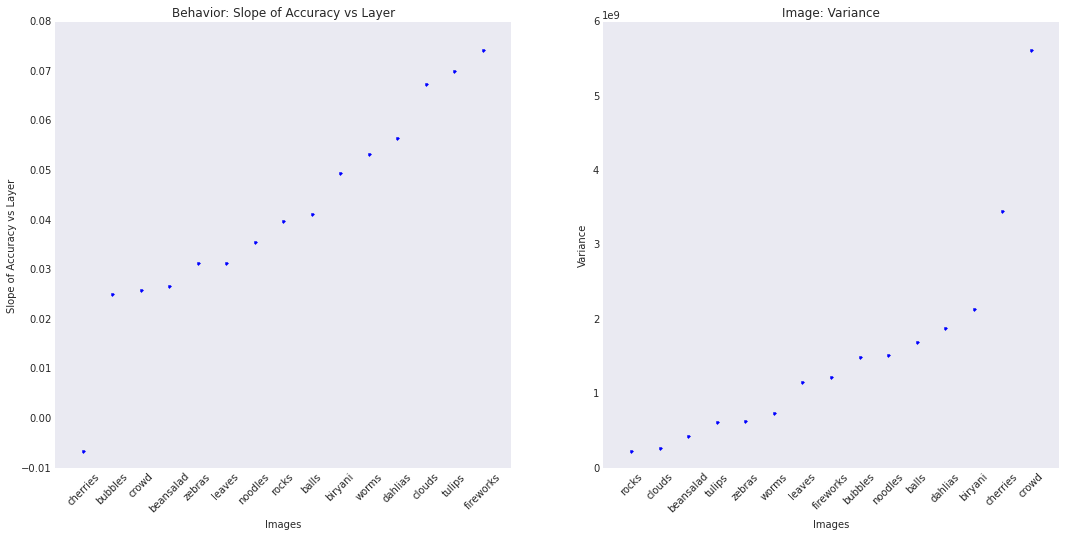

In [11]:
# slopes of the Accuracy vs Layer graphs for each image for each cnn layer.
mim = np.mean(imslopes,axis=1)
sidx = np.argsort(mim)
fig = plt.figure(figsize=(18,8))
ax = fig.add_subplot(121)
plt.plot(range(len(imnames)), mim[sidx], '.')
ax.set_xticks(range(len(imnames)))
ax.set_xticklabels(imnames[sidx], rotation=45)
plt.xlabel('Images')
plt.ylabel('Slope of Accuracy vs Layer')
plt.title('Behavior: Slope of Accuracy vs Layer')
plt.xlim([-1, 15]);

mim = np.mean(im_vars,axis=1)
sidx = np.argsort(mim)
ax = fig.add_subplot(122)
plt.plot(range(len(imnames)), mim[sidx], '.')
ax.set_xticks(range(len(imnames)))
ax.set_xticklabels(imnames[sidx], rotation=45)
plt.title('Image: Variance')
plt.xlabel('Images')
plt.ylabel('Variance')
plt.xlim([-1, 15]);

#plt.savefig('Figures/LayerSlopes')

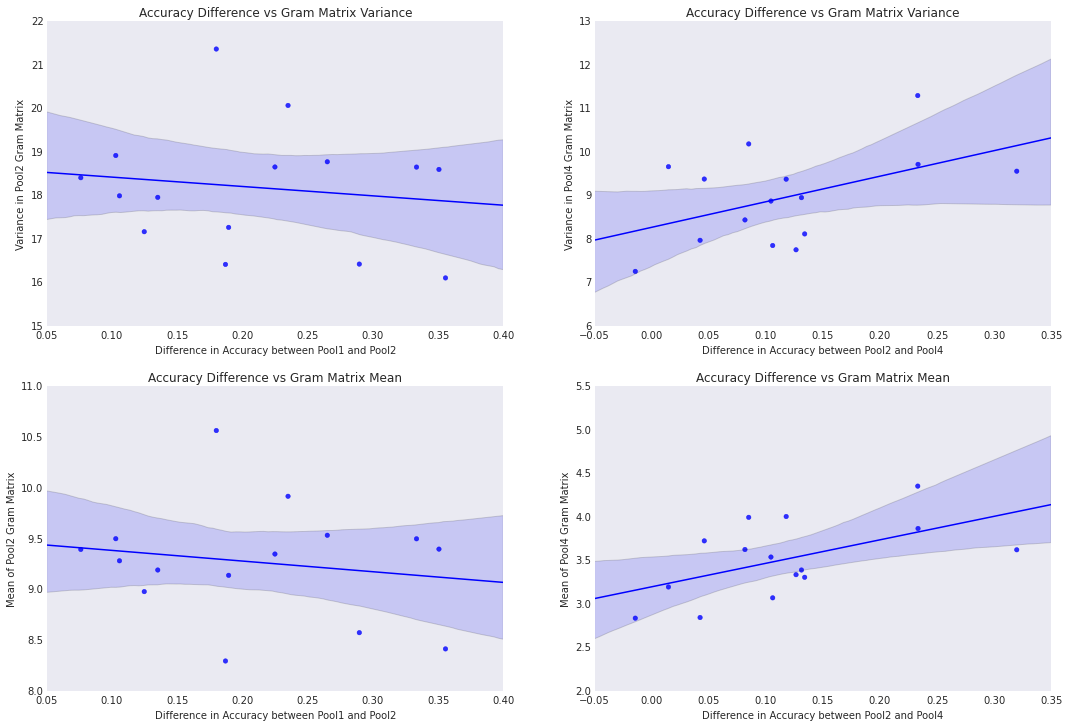

In [12]:
# Plot correlation
fig = plt.figure(figsize=(18,12))

ax = fig.add_subplot(221)
sns.regplot(x=acc_diff[:,0], y=np.log(im_vars[:,1]))
plt.xlabel('Difference in Accuracy between Pool1 and Pool2')
plt.ylabel('Variance in Pool2 Gram Matrix')
plt.title('Accuracy Difference vs Gram Matrix Variance')

ax = fig.add_subplot(222)
sns.regplot(x=acc_diff[:,1], y=np.log(im_vars[:,2]))
plt.xlabel('Difference in Accuracy between Pool2 and Pool4')
plt.ylabel('Variance in Pool4 Gram Matrix')
plt.title('Accuracy Difference vs Gram Matrix Variance')


ax = fig.add_subplot(223)
sns.regplot(x=acc_diff[:,0], y=np.log(im_means[:,1]))
plt.xlabel('Difference in Accuracy between Pool1 and Pool2')
plt.ylabel('Mean of Pool2 Gram Matrix')
plt.title('Accuracy Difference vs Gram Matrix Mean')

ax = fig.add_subplot(224)
sns.regplot(x=acc_diff[:,1], y=np.log(im_means[:,2]))
plt.xlabel('Difference in Accuracy between Pool2 and Pool4')
plt.ylabel('Mean of Pool4 Gram Matrix')
plt.title('Accuracy Difference vs Gram Matrix Mean')

#plt.savefig('Figures/var_vs_highpass')

# END
Below is other random stuff

In [ ]:
#Spatial Auto correlation
sacs = []
for imi in range(len(ims)):
    im = np.load('orig_ims/%s.npy' %(imnames[imi]) )
    a = np.correlate(im.flatten(), im.flatten())
    sacs.append(a[0])
    
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

# High pass and lowpass filtered images
highpass = []
lowpass = []
#fig = plt.figure(figsize=(15,10))

for imi in range(len(ims)):
    ax = fig.add_subplot(4,4,imi)
    im = postprocess_im(np.load('orig_ims/%s.npy' % (imnames[imi])))
    lowpass_ = ndimage.gaussian_filter(im, 10)
    gauss_highpass = im - lowpass_
    highpass.append(np.sum(gauss_highpass.flatten()))
    lowpass.append(np.sum(lowpass_.flatten()))
    #plt.imshow(gauss_highpass)